# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22 
### Date Last Modified: 2024-04-22

In [1]:
!nvidia-smi

Mon Apr 22 15:35:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P8               8W /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


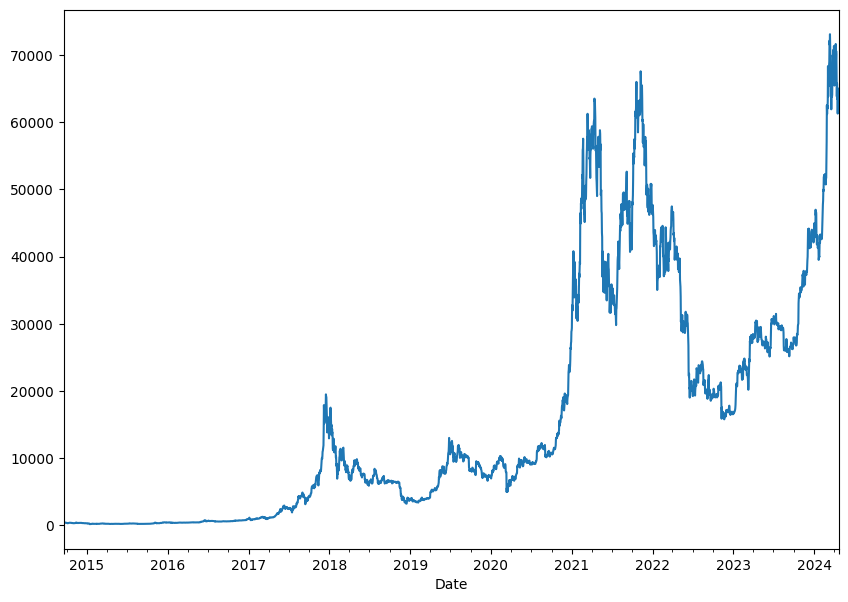

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [9]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [10]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [11]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [12]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """ 
    Plots a series of timestamps against values.
    
    Parameters
    ----------
    timestamps : list 
        list of timestamp values
    values : list 
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


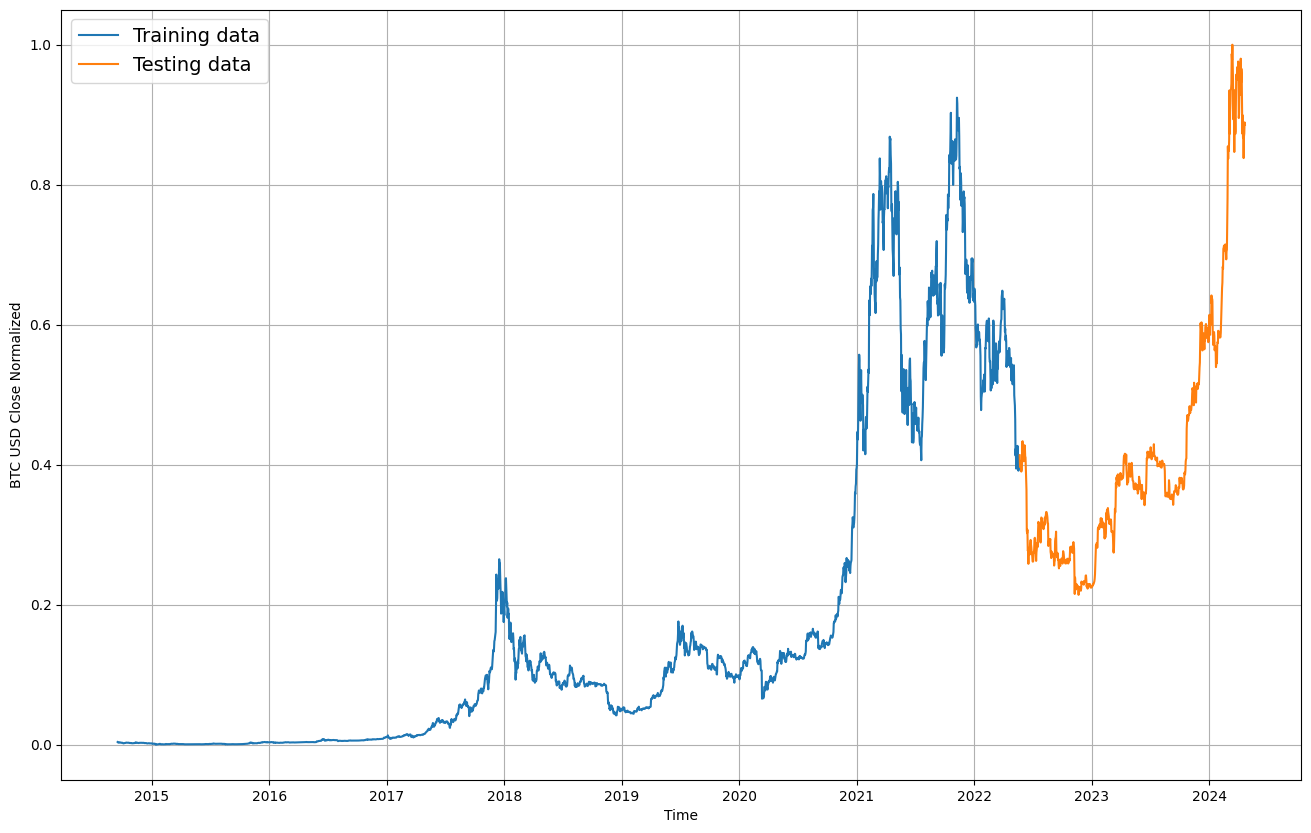

In [13]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len


plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len], title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data", yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [14]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values
        
    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [15]:
WINDOW_SIZE = 7
HORIZON = 1

In [16]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g. 
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8,)
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [18]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [19]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(*make_windows(prices_normal))
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2798, 700, 2798, 700)

In [20]:
train_windows[:3], train_labels[:3]

(<tf.Tensor: shape=(3, 7), dtype=float64, numpy=
 array([[0.00383005, 0.00337886, 0.00297225, 0.00316576, 0.00302746,
         0.00307315, 0.00353455],
        [0.00337886, 0.00297225, 0.00316576, 0.00302746, 0.00307315,
         0.00353455, 0.00336192],
        [0.00297225, 0.00316576, 0.00302746, 0.00307315, 0.00353455,
         0.00336192, 0.00320238]])>,
 <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.00336192, 0.00320238, 0.00310432])>)

## Prepare Utilities for Training

In [21]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=1,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

### FNN (Feed-forward, Densely Connected Network)

In [22]:
model_fnn_w7h1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear")
], name="FNN_W7_H1")

model_fnn_w7h1.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["mae", "mse", "mape"])

model_fnn_w7h1.build(input_shape=(None, WINDOW_SIZE))

In [23]:
model_fnn_w7h1.summary()

Model: "FNN_W7_H1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8897 (34.75 KB)
Trainable params: 8897 (34.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


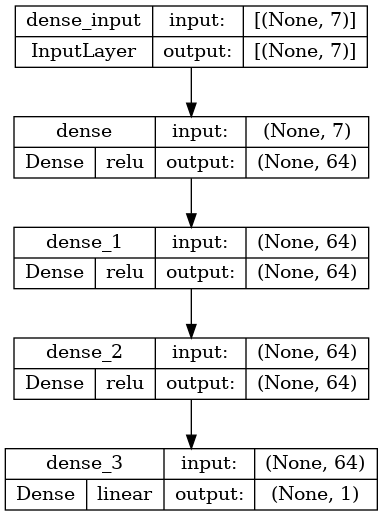

In [24]:
tf.keras.utils.plot_model(model_fnn_w7h1, show_shapes=True, show_layer_activations=True, to_file=os.path.join("model_experiments", "model_fnn_w7h1.png"))

In [25]:
history_1 = model_fnn_w7h1.fit(train_windows,
                               train_labels,
                               epochs=100,
                               batch_size=128,
                               validation_data=(test_windows, test_labels),
                               callbacks=[
                                   create_model_checkpoint(model_name=model_fnn_w7h1.name),
                                   create_early_stopping(patience=8)
                               ])

Epoch 1/100


I0000 00:00:1713780329.879525   19435 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/22 [>.............................] - ETA: 29s - loss: 0.2027 - mae: 0.2027 - mse: 0.1212 - mape: 126.0913
Epoch 1: val_loss improved from inf to 0.02501, saving model to model_experiments/FNN_W7_H1
22/22 [==============================] - 2s 30ms/step - loss: 0.1019 - mae: 0.1019 - mse: 0.0441 - mape: 3608.4690 - val_loss: 0.0250 - val_mae: 0.0250 - val_mse: 0.0013 - val_mape: 6.2051
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 0.0118 - mae: 0.0118 - mse: 2.6876e-04 - mape: 74.0029
Epoch 2: val_loss improved from 0.02501 to 0.02129, saving model to model_experiments/FNN_W7_H1
22/22 [==============================] - 0s 18ms/step - loss: 0.0137 - mae: 0.0137 - mse: 5.2695e-04 - mape: 3112.3560 - val_loss: 0.0213 - val_mae: 0.0213 - val_mse: 6.7080e-04 - val_mape: 5.6884
Epoch 3/100
16/22 [====================>.........] - ETA: 0s - loss: 0.0093 - mae: 0.0093 - mse: 3.4396e-04 - mape: 188.0751
Epoch 3: val_loss improved from 0.02129 to 0.01187, saving model to

In [26]:
model_fnn_w7h1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0086 - mae: 0.0086 - mse: 1.9812e-04 - mape: 2.0022


[0.008636821992695332,
 0.008636821992695332,
 0.00019811702077277005,
 2.002169370651245]

In [27]:
model_fnn_w7h1_preds = model_fnn_w7h1.predict(test_windows)
model_fnn_w7h1_preds.shape

22/22 [==============================] - 0s 781us/step


(700, 1)

In [28]:
test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape = (-1, 1)))
model_fnn_w7h1_preds_inv = scaler.inverse_transform(model_fnn_w7h1_preds)

In [29]:
model_fnn_w7h1_res = evaluate_pred(y_true=test_labels_inv,
                                   y_pred=model_fnn_w7h1_preds_inv)
model_fnn_w7h1_res

{'mae': 629.67065, 'mse': 1053030.8, 'rmse': 629.67065, 'mape': 1.9888517}